## Modelado 
### Selección del modelo 
Importación de librerías

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


Lectura de archivos de train y test

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Cargar los datos
data = pd.read_csv('data/dataset2.csv', encoding='utf-8', sep=',')

# Convertir la columna NUM_FALLECIDO a una variable binaria
data['MORTALIDAD'] = (data['NUM_FALLECIDO'] > 0).astype(int)

# Separar las características y el objetivo


X = data.drop(['NUM_FALLECIDO', 'MORTALIDAD'], axis=1)
y = data['MORTALIDAD']
# Aplicar SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Dividir el conjunto de datos balanceado en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


# Escalar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir el espacio de hiperparámetros para el árbol de decisión
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=1)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Predicciones
y_pred = best_model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f"Reporte de clasificación:\n{classification_report(y_test, y_pred)}")
print(f"Matriz de confusión:\n{confusion_matrix(y_test, y_pred)}")


ModuleNotFoundError: No module named 'imblearn'

Accuracy: 0.8400277970813065
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      3607
           1       0.81      0.89      0.85      3588

    accuracy                           0.84      7195
   macro avg       0.84      0.84      0.84      7195
weighted avg       0.84      0.84      0.84      7195

Matriz de confusión:
[[2848  759]
 [ 392 3196]]


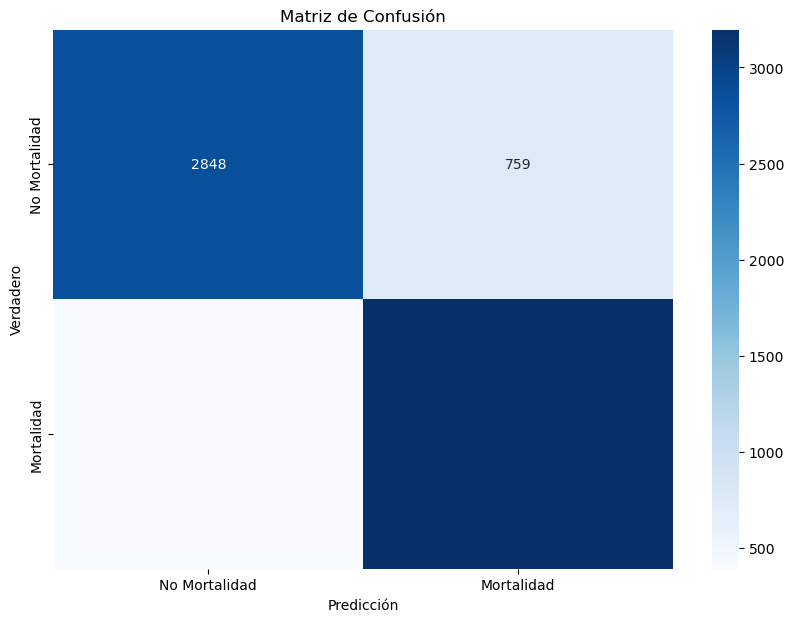

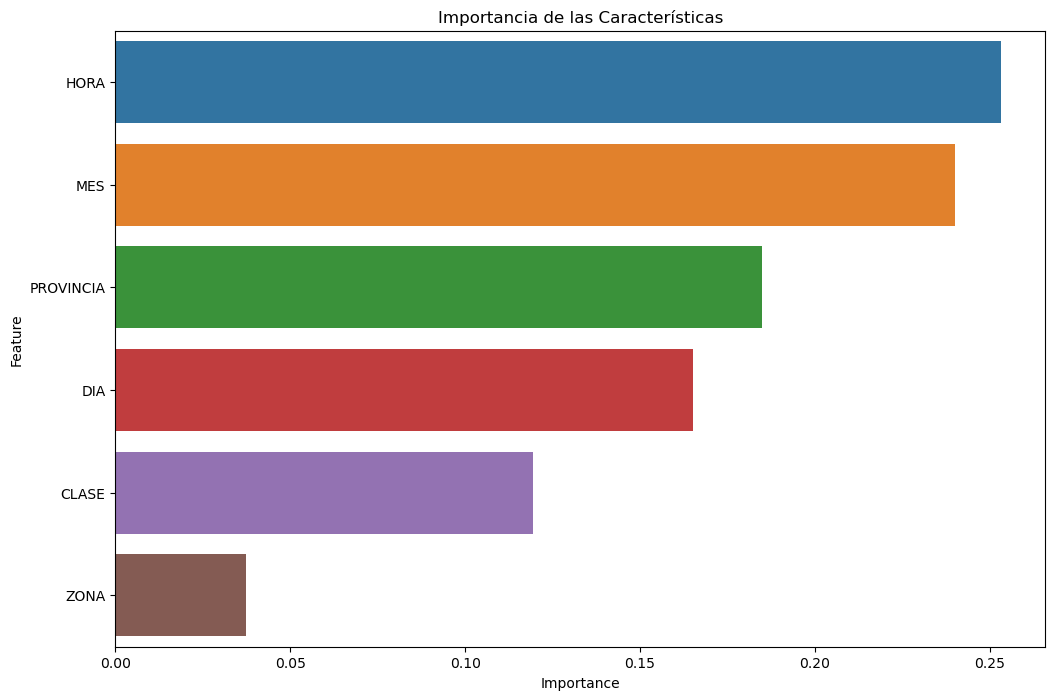

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image


# Definir el modelo con los mejores hiperparámetros
best_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

# Entrenar el modelo
best_model.fit(X_train, y_train)

# Predicciones
y_pred = best_model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f"Reporte de clasificación:\n{classification_report(y_test, y_pred)}")
print(f"Matriz de confusión:\n{confusion_matrix(y_test, y_pred)}")

# Graficar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mortalidad', 'Mortalidad'], yticklabels=['No Mortalidad', 'Mortalidad'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# Importancia de las características
feature_importances = best_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las Características')
plt.show()



Accuracy: 0.8824183460736623
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      3607
           1       0.85      0.92      0.89      3588

    accuracy                           0.88      7195
   macro avg       0.88      0.88      0.88      7195
weighted avg       0.88      0.88      0.88      7195

Matriz de confusión:
[[3047  560]
 [ 286 3302]]


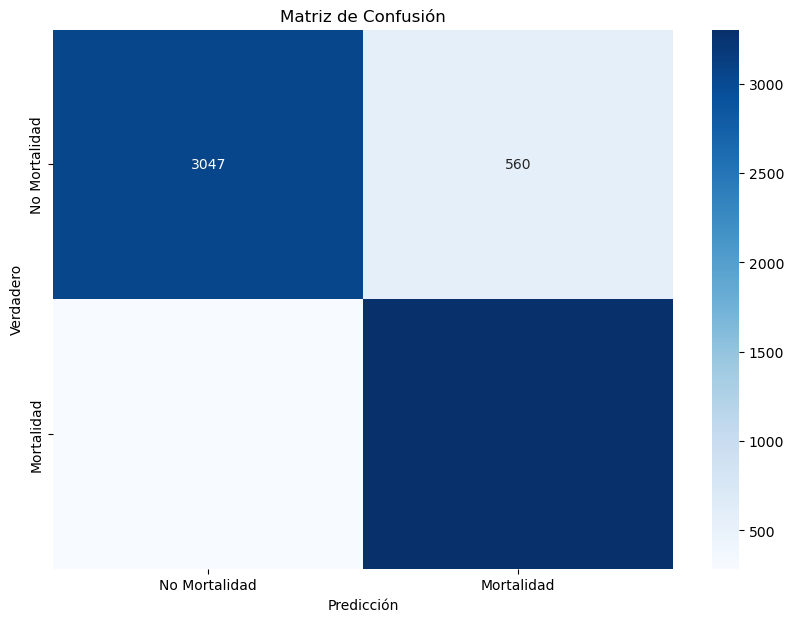

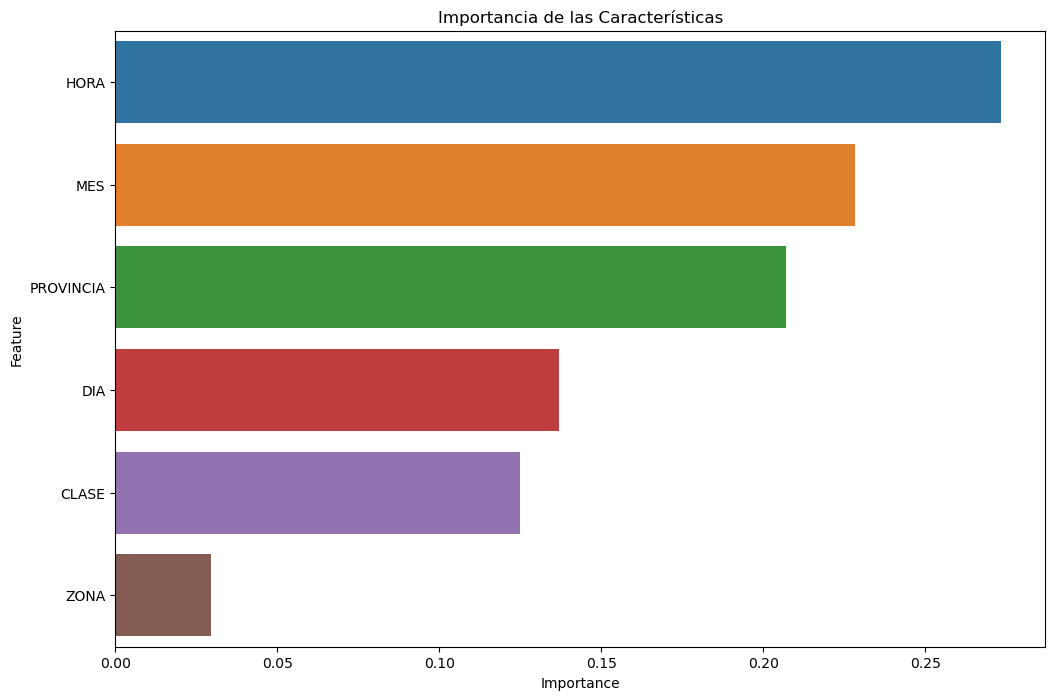

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler



# Definir el modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,       # Número de árboles en el bosque
    criterion='entropy',       # Criterio de división de los árboles
    max_depth=None,         # Profundidad máxima de los árboles
    min_samples_split=2,    # Número mínimo de muestras para dividir un nodo
    min_samples_leaf=1,     # Número mínimo de muestras en una hoja
    class_weight='balanced', # Balancear las clases
    random_state=42         # Semilla para reproducibilidad
)


# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f"Reporte de clasificación:\n{classification_report(y_test, y_pred)}")
print(f"Matriz de confusión:\n{confusion_matrix(y_test, y_pred)}")

# Graficar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mortalidad', 'Mortalidad'], yticklabels=['No Mortalidad', 'Mortalidad'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# Importancia de las características
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las Características')
plt.show()


Fitting 3 folds for each of 720 candidates, totalling 2160 fits
Mejores parámetros encontrados:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Accuracy: 0.8782487838776929
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      3607
           1       0.85      0.92      0.88      3588

    accuracy                           0.88      7195
   macro avg       0.88      0.88      0.88      7195
weighted avg       0.88      0.88      0.88      7195

Matriz de confusión:
[[3029  578]
 [ 298 3290]]


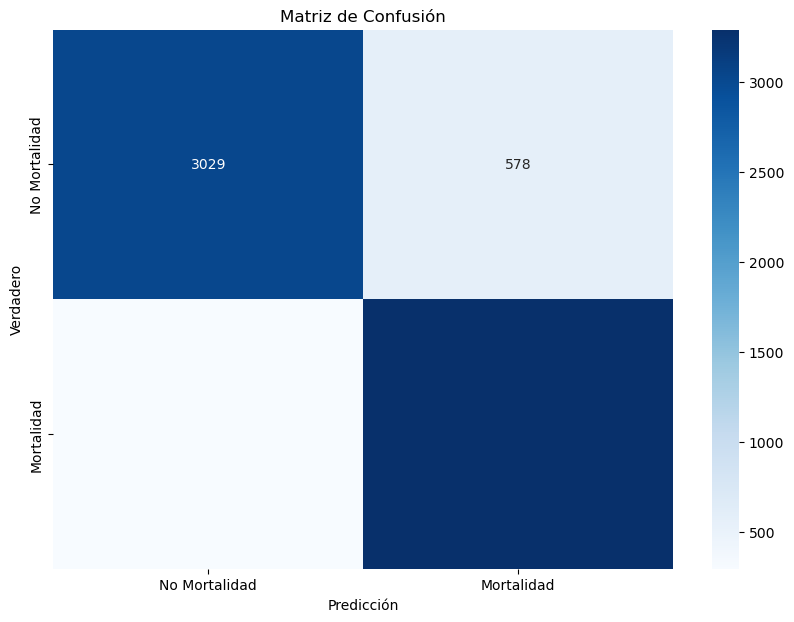

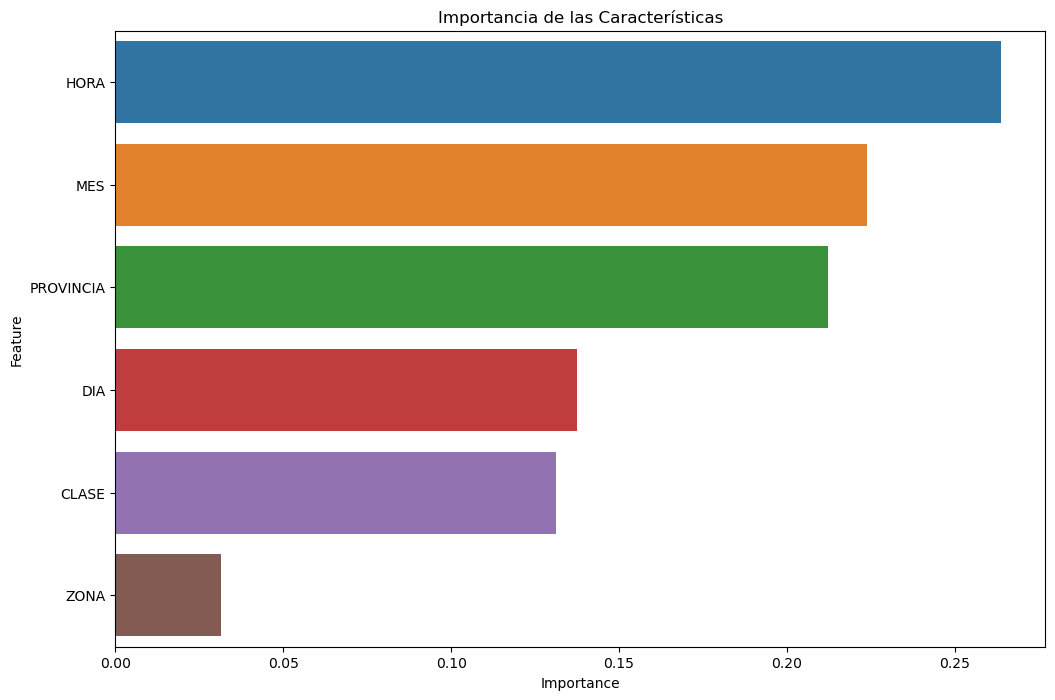

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

# Definir el rango de parámetros para la búsqueda en grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

# Realizar la búsqueda en grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados
print("Mejores parámetros encontrados: ", grid_search.best_params_)

# Utilizar el mejor modelo encontrado para hacer predicciones
best_rf_model = grid_search.best_estimator_

# Predicciones
y_pred = best_rf_model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f"Reporte de clasificación:\n{classification_report(y_test, y_pred)}")
print(f"Matriz de confusión:\n{confusion_matrix(y_test, y_pred)}")

# Graficar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mortalidad', 'Mortalidad'], yticklabels=['No Mortalidad', 'Mortalidad'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# Importancia de las características
feature_importances = best_rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las Características')
plt.show()